# Run wind farm simulation

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
# import and setup site and windTurbines
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake import IEA37SimpleBastankhahGaussian

site = IEA37Site(16)
x, y = site.initial_position.T
windTurbines = IEA37_WindTurbines()

wf_model = IEA37SimpleBastankhahGaussian(site, windTurbines)

print(wf_model)

IEA37SimpleBastankhahGaussian(PropagateDownwind, IEA37SimpleBastankhahGaussianDeficit-wake, RotorCenter-rotor-average, SquaredSum-superposition)


## All wind directions and wind speeds

Run the wind farm simulation by calling the wind farm model. As default, the model will be run for all wind directions and wind speeds defined in `site.default_wd` and `site.default_ws`(which defaults to [0,1,..,359] and [3,4,..,25])

The call will return a `SimulationResult`

In [3]:
# run wind farm simulation
sim_res = wf_model(x, y, # wind turbine positions
                   h=None, # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0, # Wind turbine types
                   wd=None, # Wind direction (defaults to site.default_wd (0,1,...,360 if not overriden))
                   ws=None, # Wind speed (defaults to site.default_ws (3,4,...,25m/s if not overriden))
                  )

## SimulationResult

A `SimulationResult` is a xarray dataset with some additional methods and attributes. 
It has the coordinates

- `wt`: Wind turbine number
- `wd`: Ambient reference wind direction
- `ws`: Ambient reference wind speed
- `x`,`y`,`h`: position and hub height of wind turbines

and data variables:

- `WD`: Local free-stream wind direction
- `WS`: Local free-stream wind speed
- `TI`: Local free-stream turbulence intensity
- `P`: Probability of flow case (wind direction and wind speed)
- `WS_eff`: Effetive local wind speed [m/s]
- `TI_eff`: Effective local turbulence intensity
- `power`: Effective power production [W]
- `ct`: Thrust coefficient
- `Yaw`: Yaw misalignment [deg]

where "effective" means "including wake effects"
 

In [4]:
sim_res

<xarray.SimulationResult>
Dimensions:   (wd: 360, ws: 1, wt: 16)
Coordinates:
  * wt        (wt) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * wd        (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws        (ws) float64 9.8
    x         (wt) float64 0.0 650.0 200.9 -525.9 ... -401.7 401.7 1.052e+03
    y         (wt) float64 0.0 0.0 618.2 382.1 ... -1.236e+03 -1.236e+03 -764.1
    h         (wt) float64 110.0 110.0 110.0 110.0 ... 110.0 110.0 110.0 110.0
    type      (wt) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    WS_eff    (wt, wd, ws) float64 9.776 9.761 9.738 9.704 ... 9.049 8.888 8.775
    TI_eff    (wt, wd, ws) float64 0.075 0.075 0.075 0.075 ... 0.075 0.075 0.075
    Power     (wt, wd, ws) float64 3.309e+06 3.284e+06 ... 2.005e+06 1.869e+06
    CT        (wt, wd, ws) float64 0.8889 0.8889 0.8889 ... 0.8889 0.8889 0.8889
    WS        (ws) float64 9.8
    WD        (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    TI        float64 0.075
    ws_lower  (ws) float64 9.3
    ws_upper  (ws) float64 10.3
    P         (wd) float64 0.001111 0.001111 0.001111 ... 0.001111 0.001111
    Yaw       (wt, wd, ws) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    wd_bin_size:  1

Data can be selected using the xarray `sel` method, e.g. the power production of wind turbine 3 when the wind is coming from the East (90deg) is 2.634MW:

In [5]:
sim_res.Power.sel(wt=3, wd=0)

<xarray.DataArray 'Power' (ws: 1)>
array([2624293.287983])
Coordinates:
    wt       int32 3
    wd       int32 0
  * ws       (ws) float64 9.8
    x        float64 -525.9
    y        float64 382.1
    h        float64 110.0
    type     int32 0
Attributes:
    Description:  Power [W]

Data can be plotted using the xarray `plot` method, e.g. the power production of wind turbine 0 as a function of wind direction

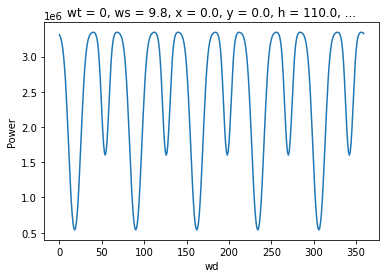

In [6]:
sim_res.Power.sel(wt=0).plot()

### AEP calculation

Furthermore, `SimulationResult`, contains a method, `aep` that calculates the Annual Energy Production

In [7]:
sim_res.aep()

<xarray.DataArray 'AEP [GWh]' (wt: 16, wd: 360, ws: 1)>
array([[[0.03221141],
        [0.03195991],
        [0.03157906],
        ...,
        [0.03252982],
        [0.03247122],
        [0.03237201]],

       [[0.03225682],
        [0.03244372],
        [0.03253571],
        ...,
        [0.03030697],
        [0.03129127],
        [0.0319047 ]],

       [[0.03221142],
        [0.03195991],
        [0.03157907],
        ...,
...
        ...,
        [0.01386263],
        [0.01589217],
        [0.01796251]],

       [[0.02331829],
        [0.02392321],
        [0.02516424],
        ...,
        [0.022921  ],
        [0.02341593],
        [0.02331792]],

       [[0.01773565],
        [0.01819481],
        [0.01951149],
        ...,
        [0.02150479],
        [0.01951311],
        [0.01819518]]])
Coordinates:
  * wt       (wt) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * wd       (wd) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * ws       (ws) float64 9.8
    x        (wt) float64 0.0 650.0 200.9 -525.9 ... -401.7 401.7 1.052e+03
    y        (wt) float64 0.0 0.0 618.2 382.1 ... -1.236e+03 -1.236e+03 -764.1
    h        (wt) float64 110.0 110.0 110.0 110.0 ... 110.0 110.0 110.0 110.0
    type     (wt) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    Description:  Annual energy production [GWh]

The total wind farm AEP is obtained using the `sum` method

In [8]:
sim_res.aep().sum()

<xarray.DataArray 'AEP [GWh]' ()>
array(373.20664521)

The `aep` method take an optional input, `with_wake_loss` (default is True), which can be used to e.g. calculate the wake loss of the wind farm

In [9]:
aep_with_wake_loss = sim_res.aep().sum().data
aep_witout_wake_loss = sim_res.aep(with_wake_loss=False).sum().data
(aep_witout_wake_loss-aep_with_wake_loss) / aep_witout_wake_loss

0.20741308303216552

## Time series

Instead of simulating all wind speeds and wind directions, it is also possible to simulate time series of wind speed and wind directions.

This allows simulation of time-dependent inflow conditions, e.g. combinations of wd,ws,shear,ti,density,etc. and turbine operation, e.g. periods where one or more wind turbines are stopped due to failure or maintaince

Note, however, that PyWake considers the time series as discrete stationary conditions, i.e. a gust hits the whole wind farm at the same time

In [10]:
# load a time series of wd, ws and ti
from py_wake.tests.test_files import tfp
d = np.load(tfp + "time.npz")
n_days=30
wd, ws, ws_std = [d[k][:6*24*n_days] for k in ['wd', 'ws', 'ws_std']]
ti = np.minimum(ws_std/ws,.5)
time_stamp = np.arange(len(wd))/6/24

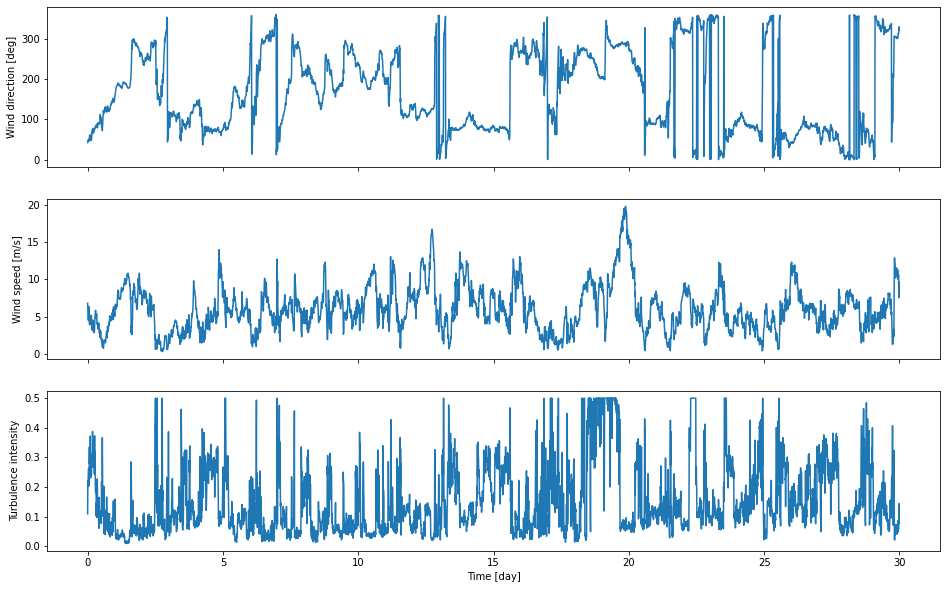

In [11]:
# plot time series
axes = plt.subplots(3,1, sharex=True, figsize=(16,10))[1]
for ax, (v,l) in zip(axes, [(wd, 'Wind direction [deg]'),(ws,'Wind speed [m/s]'),(ti,'Turbulence intensity')]):
    ax.plot(time_stamp, v)
    ax.set_ylabel(l)
_ = ax.set_xlabel('Time [day]')

**Time-dependent site data**

Add time-dependent turbulence intensity to site

In [12]:
import xarray as xr
site = IEA37Site(16)
site.ds['TI'] = xr.DataArray(ti,[('time',time_stamp)])

**Time-dependent wind turbine operation**

Extend the wind turbine with a `operating` setting (0=stopped, 1=normal operation)

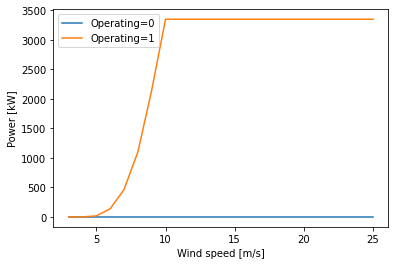

In [13]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList, PowerCtTabular

# replace powerCtFunction
windTurbines.powerCtFunction = PowerCtFunctionList(
    key='operating',
    powerCtFunction_lst=[PowerCtTabular(ws=[0, 100], power=[0, 0], power_unit='w', ct=[0, 0]), # 0=No power and ct
                         IEA37_WindTurbines().powerCtFunction], # 1=Normal operation
    default_value=1)

# plot power curves
u = np.arange(3,26)
for op in [0,1]:
    plt.plot(u, windTurbines.power(u, operating=op)/1000, label=f'Operating={op}')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
_ = plt.legend()

Make time-dependent operating variable

In [14]:
operating = np.ones((len(x), len(time_stamp))) # shape=(#wt, #time stamps)
operating[0,(time_stamp>5)&(time_stamp<15)] = 0 # wt0 not operating from day 5 to 15

Call the wind farm model with the `time=time_stamp` and the time-dependent `operating` key-word argument

In [15]:
# setup new WindFarmModel with site containing time-dependent TI and run simulation
wf_model = IEA37SimpleBastankhahGaussian(site, windTurbines)
sim_res_time = wf_model(x, y, # wind turbine positions
                        wd=wd, # Wind direction (defaults to site.default_wd (0,1,...,360 if not overriden))
                        ws=ws, # Wind speed (defaults to site.default_ws (3,4,...,25m/s if not overriden))
                        time=time_stamp,
                        operating=operating # time dependent operating variable
                  )

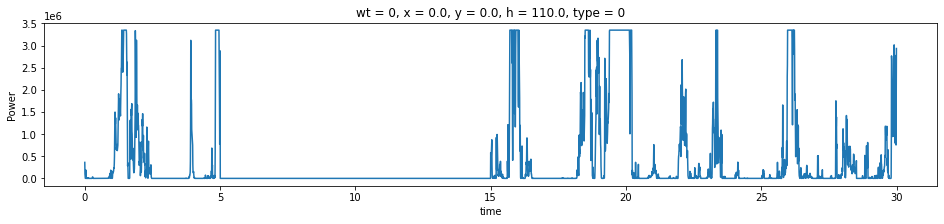

In [16]:
sim_res_time.Power.sel(wt=0).plot(figsize=(16,3))

In the no-operating periode time=5..15, the power is 0 as it should be

## Flow map

Finally, `SimulationResult` has a `flow_map` method which returns a `FlowMap` object

In [17]:
flow_map = sim_res.flow_map(grid=None, # defaults to HorizontalGrid(resolution=500, extend=0.2), see below
                            wd=270, 
                            ws=None)

### plot_wake_map

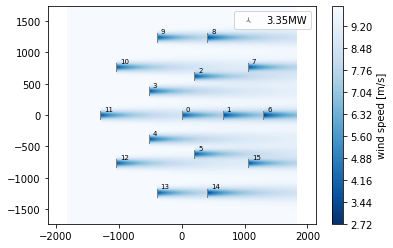

In [18]:
flow_map.plot_wake_map()

(-1820.0, 1820.0, -1730.9229, 1730.9229)

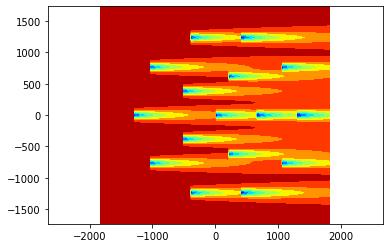

In [19]:
flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
                       cmap='jet', # color map
                       plot_colorbar=False, 
                       plot_windturbines=False, 
                       ax=None)
plt.axis('equal')

#### Grid

The grid argument should be either 

- a `HorizontalGrid`(same as `XYGrid`), `YZGrid` or 
- a tuple(X, Y, x, y, h) where X, Y is the meshgrid for visualizing the data and x, y, h are the flattened grid points

 
##### HorizontalGrid (XYGrid)


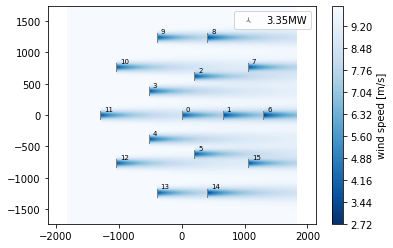

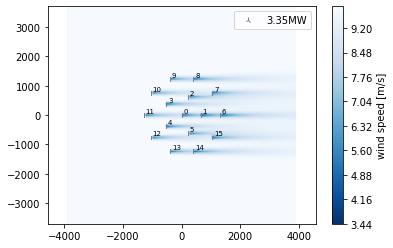

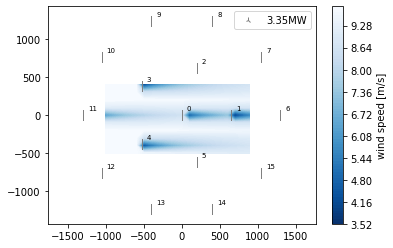

In [20]:
from py_wake import HorizontalGrid
for grid in [None, # defaults to HorizontalGrid(resolution=500, extend=0.2)
             HorizontalGrid(x=None, y=None, resolution=100, extend=1), # custom resolution and extend
             HorizontalGrid(x = np.arange(-1000,1000,100),
                            y = np.arange(-500,500,100)) # custom x and y
            ]:
    plt.figure()
    sim_res.flow_map(grid=grid, wd=270, ws=None).plot_wake_map()

##### YZGrid
Vertical grid in the YZ plane

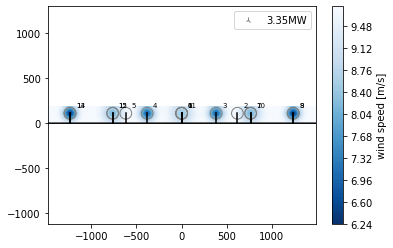

In [21]:
from py_wake import YZGrid
for grid in [YZGrid(x=-100, y=None, resolution=100, extend=.1), # custom resolution and extend
             ]:
    plt.figure()
    sim_res.flow_map(grid=grid, wd=270, ws=None).plot_wake_map()